In [68]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "report"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [69]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [70]:
X_train_full.shape

(60000, 28, 28)

In [71]:
X_train_full.dtype

dtype('uint8')

In [72]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [73]:
import keras_tuner as kt
from keras import layers

In [74]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [75]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        # model = keras.Sequential()
        # model.add(layers.Flatten())
        # model.add(
        #     layers.Dense(
        #         units=hp.Int("units", min_value=32, max_value=512, step=32),
        #         activation="relu",
        #     )
        # )
        # model.add(layers.Dense(10, activation="softmax"))
        # model.compile(
        #     optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
        # )

        model = keras.Sequential()
        model.add(keras.layers.Flatten(input_shape=(28, 28)))

        # Tune the number of units in the first Dense layer
        for i in range(1, hp.Int("n_layers", min_value=1,max_value=3, step=1)):
            model.add(keras.layers.Dense(
                units=hp.Int(f"units_{i}", min_value=200, max_value=600, step=100),
                activation='relu'))

        # Output layer
        model.add(keras.layers.Dense(10, activation='softmax'))

        # Tune the learning rate for the optimizer
        hp_learning_rate = hp.Choice('learning_rate', values=[0.3, 0.2, 0.1, 0.03, 0.02, 0.01])

        model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy'])

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64]),
            **kwargs,
        )

In [76]:
# def model_builder(hp):
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(28, 28)))

#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=200, max_value=600, step=100)

#     for i in range(1, hp.Int("n_layers", 1,3)):
#         model.add(keras.layers.Dense(units=hp_units, activation='relu'))

#     # Output layer
#     model.add(keras.layers.Dense(10, activation='softmax'))

#     # Tune the learning rate for the optimizer
#     hp_learning_rate = hp.Choice('learning_rate', values=[3e-1, 2e-1, 1e-1])

#     model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
#                 loss="sparse_categorical_crossentropy",
#                 metrics=['accuracy'])

#     return model

In [77]:
tuner = kt.RandomSearch(MyHyperModel(),
                     objective='val_accuracy',
                     max_trials=5,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True)

/home/vinh/hv/iai600/assignments/7/repo/dev/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [78]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
tensorboard_cb = keras.callbacks.TensorBoard('my_dir')

In [79]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=[stop_early, tensorboard_cb])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 00m 49s]
val_accuracy: 0.9254000186920166

Best val_accuracy So Far: 0.984000027179718
Total elapsed time: 00h 11m 49s


In [80]:
tuner.results_summary()

Results summary
Results in my_dir/intro_to_kt
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
n_layers: 2
learning_rate: 0.1
units_1: 500
units_2: 500
batch_size: 32
Score: 0.984000027179718

Trial 3 summary
Hyperparameters:
n_layers: 3
learning_rate: 0.1
units_1: 400
units_2: 300
batch_size: 32
Score: 0.9825999736785889

Trial 0 summary
Hyperparameters:
n_layers: 3
learning_rate: 0.01
units_1: 200
units_2: 200
batch_size: 32
Score: 0.9801999926567078

Trial 2 summary
Hyperparameters:
n_layers: 2
learning_rate: 0.2
units_1: 200
units_2: 600
batch_size: 64
Score: 0.9787999987602234

Trial 4 summary
Hyperparameters:
n_layers: 1
learning_rate: 0.03
units_1: 300
units_2: 600
batch_size: 64
Score: 0.9254000186920166


In [81]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The number of layers is {best_hps.get('n_layers')} and the number of batch size is {best_hps.get('batch_size')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 500 and the optimal learning rate for the optimizer is 0.1.
The number of layers is 2 and the number of batch size is 32.



In [82]:
def print_hp(hp):
    print(f"""
Number of units in the first densely-connected layer is {hp.get('units_1')}.
Number of layers is {hp.get('n_layers')}.
Learning rate is {hp.get('learning_rate')}.
Batch size is {hp.get('batch_size')}.
    """)

In [83]:
def print_test_eval(m):
    eval_result = m.evaluate(X_test, y_test)
    print(f"[test loss: {eval_result[0]}, test accuracy: {eval_result[1]}]:")

# Best model

In [84]:
x_all = np.concatenate((X_train, X_valid))
y_all = np.concatenate((y_train, y_valid))

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_all, y_all, epochs=50, validation_split=0.2)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9115 - loss: 0.3093 - val_accuracy: 0.9603 - val_loss: 0.1505
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9584 - loss: 0.1462 - val_accuracy: 0.9711 - val_loss: 0.1057
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9713 - loss: 0.1015 - val_accuracy: 0.9764 - val_loss: 0.0871
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9788 - loss: 0.0770 - val_accuracy: 0.9782 - val_loss: 0.0773
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9835 - loss: 0.0608 - val_accuracy: 0.9797 - val_loss: 0.0715
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9870 - loss: 0.0489 - val_accuracy: 0.9798 - val_loss: 0.0683
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9899 - loss: 0.0399 - val_accuracy: 0.9804 - val_loss: 0.0663
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9925 - loss: 0.0327 - 

In [85]:
import pandas as pd

def draw_learning_curve(htr, fig_name, title):
    pd.DataFrame(htr.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Score")

    save_fig(fig_name)

    plt.show()

In [86]:
print_hp(best_hps)


Number of units in the first densely-connected layer is 500.
Number of layers is 2.
Learning rate is 0.1.
Batch size is 32.
    


Saving figure best_model_learning_curve


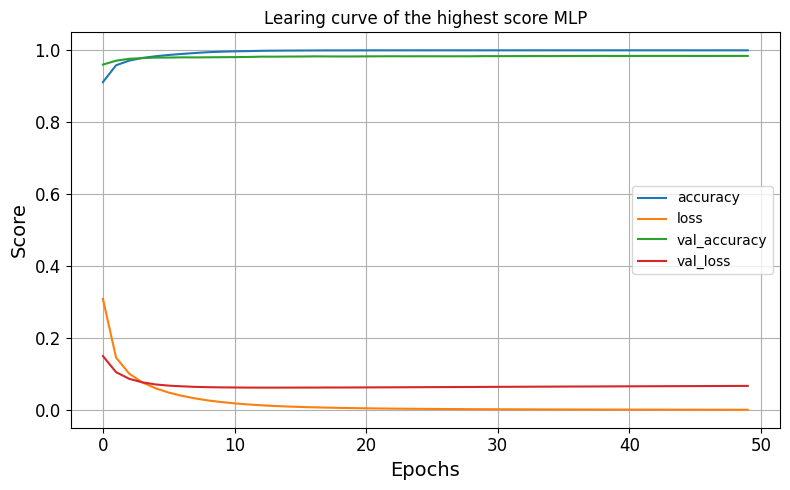

In [93]:
draw_learning_curve(history, "best_model_learning_curve", "Learing curve of the highest score MLP")

In [88]:
print_test_eval(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9815 - loss: 0.0657
[test loss: 0.06566977500915527, test accuracy: 0.9815000295639038]:


# Worst model

In [89]:
worst_hp = tuner.get_best_hyperparameters(num_trials=10)[4]
print_hp(worst_hp)


Number of units in the first densely-connected layer is 300.
Number of layers is 1.
Learning rate is 0.03.
Batch size is 64.
    


In [90]:
worst_model = tuner.hypermodel.build(worst_hp)

history2 = worst_model.fit(x_all, y_all, epochs=50, validation_split=0.2)

Epoch 1/50


/home/vinh/hv/iai600/assignments/7/repo/dev/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8481 - loss: 0.5952 - val_accuracy: 0.9072 - val_loss: 0.3643
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8937 - loss: 0.3870 - val_accuracy: 0.9168 - val_loss: 0.3184
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9014 - loss: 0.3537 - val_accuracy: 0.9202 - val_loss: 0.2994
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9061 - loss: 0.3363 - val_accuracy: 0.9226 - val_loss: 0.2885
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9091 - loss: 0.3252 - val_accuracy: 0.9249 - val_loss: 0.2813
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9117 - loss: 0.3172 - val_accuracy: 0.9255 - val_loss: 0.2761
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9135 - loss: 0.3111 - val_accuracy: 0.9261 - val_loss: 0.2721
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9145 - loss: 0.3062 - val_accurac

Saving figure worst_model_learning_curve


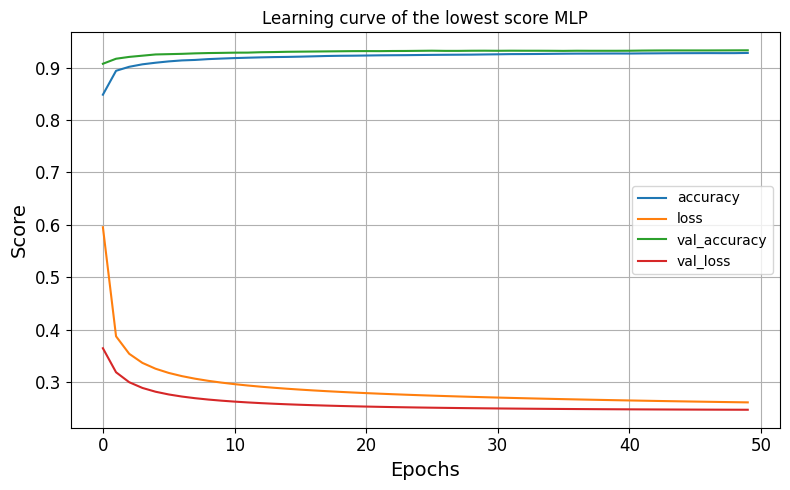

In [94]:
draw_learning_curve(history2, "worst_model_learning_curve", "Learning curve of the lowest score MLP")

In [92]:
print_test_eval(worst_model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9260 - loss: 0.2678
[test loss: 0.26784467697143555, test accuracy: 0.9259999990463257]:
